In [ ]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.impute import SimpleImputer

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [35]:
def mape(y_true, y_pred):
    """
    Mean Absolute Percentage Error (MAPE)
    Ignores zero targets to avoid division by zero.
    Returns percentage.
    """
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    non_zero_mask = y_true != 0
    if non_zero_mask.sum() == 0:
        return np.nan

    return np.mean(
        np.abs((y_true[non_zero_mask] - y_pred[non_zero_mask]) / y_true[non_zero_mask])
    ) * 100


In [36]:
train = pd.read_csv("train_split_merged_expanded_data.csv", parse_dates=["date"])
val   = pd.read_csv("val_split_merged_expanded_data.csv", parse_dates=["date"])
test  = pd.read_csv("test_split_merged_expanded_data_filtered.csv", parse_dates=["date"])

print("Train:", train.shape, "Val:", val.shape, "Test:", test.shape)
print("Train dates:", train["date"].min(), "→", train["date"].max())
print("Val dates:", val["date"].min(), "→", val["date"].max())
print("Test dates:", test["date"].min(), "→", test["date"].max())


Train: (7475, 11) Val: (1840, 11) Test: (1830, 11)
Train dates: 2013-07-01 00:00:00 → 2017-07-31 00:00:00
Val dates: 2017-08-01 00:00:00 → 2018-07-31 00:00:00
Test dates: 2018-08-01 00:00:00 → 2019-07-30 00:00:00


In [37]:
def add_features(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df["date"] = pd.to_datetime(df["date"])

    # -------------------------
    # Calendar features
    # -------------------------
    df["Wochentag"] = df["date"].dt.day_name()
    df["Month"]     = df["date"].dt.month
    df["dayofyear"] = df["date"].dt.dayofyear

    # Seasonality encoding (cyclical)
    df["sin_season"] = np.sin(2 * np.pi * df["dayofyear"] / 365)
    df["cos_season"] = np.cos(2 * np.pi * df["dayofyear"] / 365)

    df["is_weekend"] = df["Wochentag"].isin(["Saturday", "Sunday"]).astype(int)

    # Integer/calendar flags (force 0/1 and no NaNs)
    for col in ["KielerWoche", "school_holiday", "public_holiday"]:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors="coerce").fillna(0).astype(int)

    return df

train_fe = add_features(train)
val_fe   = add_features(val)
test_fe  = add_features(test)

print("Feature engineering done.")


Feature engineering done.


In [38]:
train_fe["dataset"] = "train"
val_fe["dataset"]   = "val"
test_fe["dataset"]  = "test"

df_all = pd.concat([train_fe, val_fe, test_fe], ignore_index=True)
df_all = df_all.sort_values(["warengruppe", "date"])

# Lags of target (umsatz) capture short-term and weekly memory
for lag in [1, 2, 7, 14]:
    df_all[f"lag_{lag}"] = df_all.groupby("warengruppe")["umsatz"].shift(lag)

# Rolling mean & std PER warengruppe (shift(1) avoids leakage)
for window in [7, 14, 30]:
    df_all[f"roll{window}_mean"] = (
        df_all.groupby("warengruppe")["umsatz"]
              .transform(lambda s: s.shift(1).rolling(window, min_periods=1).mean())
    )
    df_all[f"roll{window}_std"] = (
        df_all.groupby("warengruppe")["umsatz"]
              .transform(lambda s: s.shift(1).rolling(window, min_periods=2).std())
    )


# Sanity check: first rows per WG should have NaNs in rolling features (expected)
print(df_all.groupby("warengruppe")[["roll7_mean", "roll7_std"]].head(3))

# -------------------------
# Missingness flags for lag/rolling features
# (keeps information about "empty cells" after imputation)
# -------------------------
lag_roll_cols = [c for c in df_all.columns if c.startswith("lag_") or c.startswith("roll")]
for c in lag_roll_cols:
    df_all[c + "_isna"] = df_all[c].isna().astype(int)


# One-hot weekday (done on ALL so columns match across splits)
df_all = pd.get_dummies(df_all, columns=["Wochentag"], drop_first=False)

train_fe = df_all[df_all["dataset"] == "train"].copy()
val_fe   = df_all[df_all["dataset"] == "val"].copy()
test_fe  = df_all[df_all["dataset"] == "test"].copy()

print("Lag + rolling + one-hot done.")


     roll7_mean  roll7_std
0           NaN        NaN
5    148.828353        NaN
10   154.311055   7.753712
1           NaN        NaN
6    535.856285        NaN
11   541.318536   7.724790
2           NaN        NaN
7    201.198426        NaN
12   233.229840  45.299260
3           NaN        NaN
8     65.890169        NaN
13    70.217043   6.119124
4           NaN        NaN
9    317.475875        NaN
14   350.552278  46.777098
612         NaN        NaN
618   48.605400        NaN
624   59.368168  15.220853
Lag + rolling + one-hot done.


In [39]:
weekday_cols = [c for c in train_fe.columns if c.startswith("Wochentag_")]

na_flag_cols = [c for c in train_fe.columns if c.endswith("_isna")]



feature_cols = [
    "Temperatur",
    "KielerWoche",
    "school_holiday",
    "public_holiday",
    "Month",
    "sin_season",
    "cos_season",
    "is_weekend",
    "lag_1",
    "lag_2",
    "lag_7",
    "lag_14",
    "roll7_mean",
    "roll7_std",
    "roll14_mean",
    "roll14_std",
    "roll30_mean",
    "roll30_std",
] + weekday_cols + na_flag_cols

print("NA-flag features:", len(na_flag_cols))
print("Example NA-flag cols:", na_flag_cols[:5])


target_col = "umsatz"

# Export feature dataset (train only)
features_dataset = train_fe[feature_cols + [target_col]].copy()

features_dataset.to_csv(
    "nn_feature_dataset_train.csv",
    index=False
)

print("Saved: nn_feature_dataset_train.csv")
print("Number of features:", len(feature_cols))


NA-flag features: 10
Example NA-flag cols: ['lag_1_isna', 'lag_2_isna', 'lag_7_isna', 'lag_14_isna', 'roll7_mean_isna']
Saved: nn_feature_dataset_train.csv
Number of features: 35


In [40]:
def build_model(input_dim: int) -> tf.keras.Model:
    model = Sequential([
        Dense(64, activation="relu", input_shape=(input_dim,)),
        Dropout(0.1),
        Dense(32, activation="relu"),
        Dense(1)
    ])

    model.compile(
        optimizer="adam",
        loss="mse"
    )
    return model




 Warengruppe 1
Rows: train=1462, val=357, test=355


/usr/local/python/3.12.1/lib/python3.12/site-packages/keras/src/layers/core/dense.py:106: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


NN R² (train): 0.624 | MSE: 593.30 | MAE: 18.22 | MAPE: 16.60%
NN R² (val):   0.532 | MSE: 839.88 | MAE: 21.71 | MAPE: 18.49%


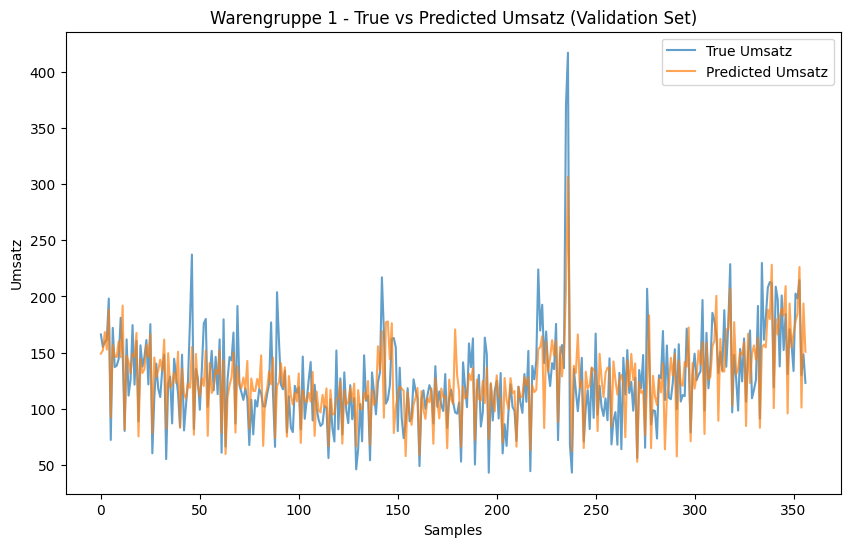


 Warengruppe 2
Rows: train=1462, val=357, test=355


/usr/local/python/3.12.1/lib/python3.12/site-packages/keras/src/layers/core/dense.py:106: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


NN R² (train): 0.892 | MSE: 2165.69 | MAE: 31.12 | MAPE: 7.64%
NN R² (val):   0.896 | MSE: 1674.42 | MAE: 31.04 | MAPE: 8.86%


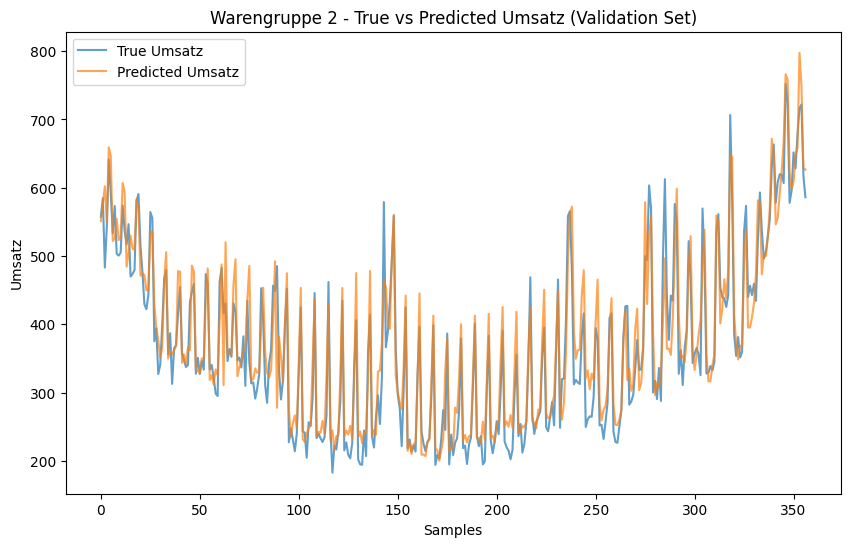


 Warengruppe 3
Rows: train=1462, val=357, test=355


/usr/local/python/3.12.1/lib/python3.12/site-packages/keras/src/layers/core/dense.py:106: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


NN R² (train): 0.876 | MSE: 708.03 | MAE: 18.64 | MAPE: 12.66%
NN R² (val):   0.871 | MSE: 741.60 | MAE: 20.48 | MAPE: 14.25%


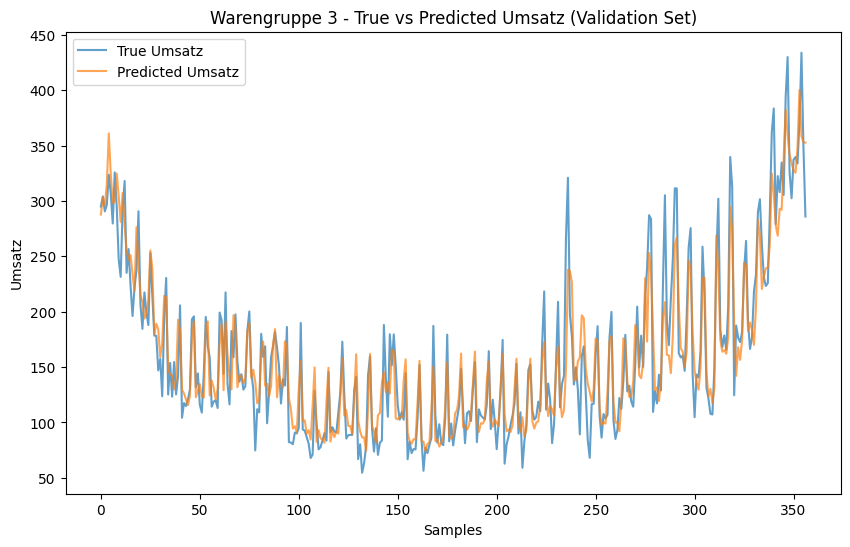


 Warengruppe 4
Rows: train=1409, val=357, test=354


/usr/local/python/3.12.1/lib/python3.12/site-packages/keras/src/layers/core/dense.py:106: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


NN R² (train): 0.603 | MSE: 550.11 | MAE: 16.54 | MAPE: 19.47%
NN R² (val):   0.085 | MSE: 640.33 | MAE: 19.29 | MAPE: 24.48%


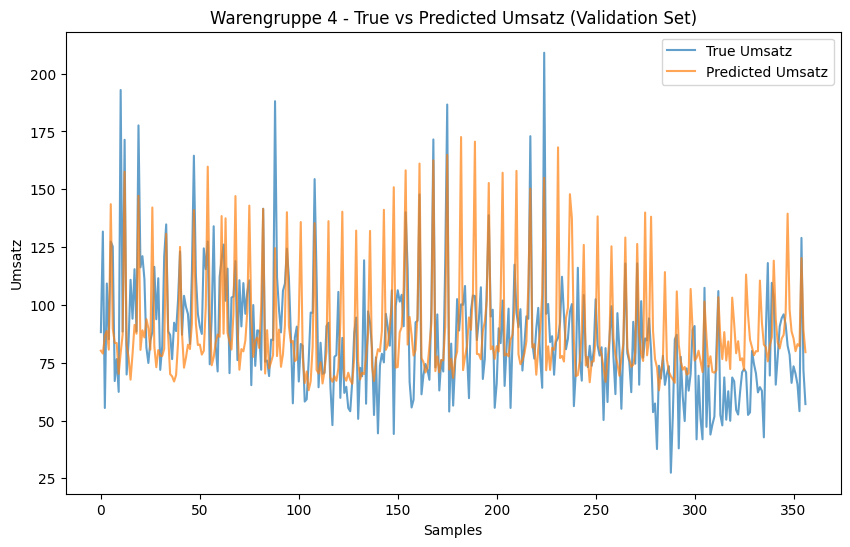


 Warengruppe 5
Rows: train=1462, val=357, test=355


/usr/local/python/3.12.1/lib/python3.12/site-packages/keras/src/layers/core/dense.py:106: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


NN R² (train): 0.364 | MSE: 6563.06 | MAE: 36.18 | MAPE: 12.31%
NN R² (val):   0.235 | MSE: 5940.85 | MAE: 42.91 | MAPE: 16.03%


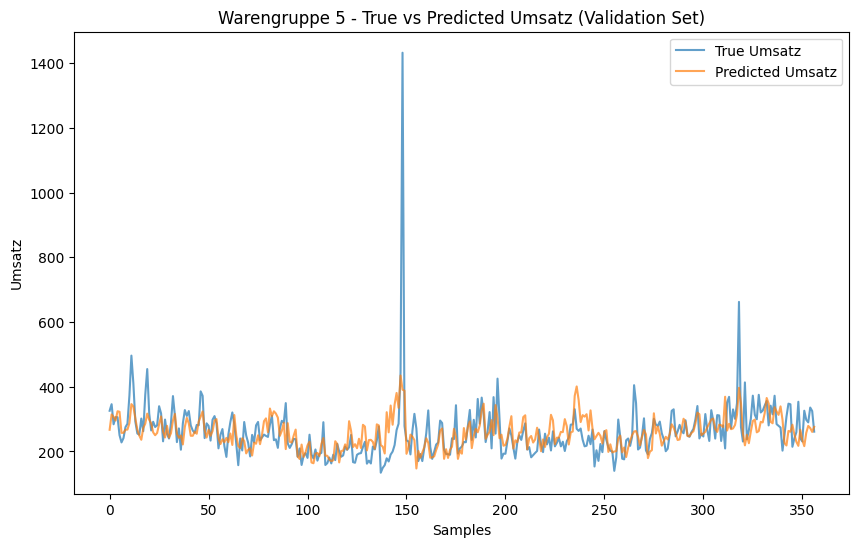


 Warengruppe 6
Rows: train=218, val=55, test=56


/usr/local/python/3.12.1/lib/python3.12/site-packages/keras/src/layers/core/dense.py:106: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


NN R² (train): 0.533 | MSE: 482.75 | MAE: 16.55 | MAPE: 29.10%
NN R² (val):   0.518 | MSE: 470.02 | MAE: 16.87 | MAPE: 43.05%


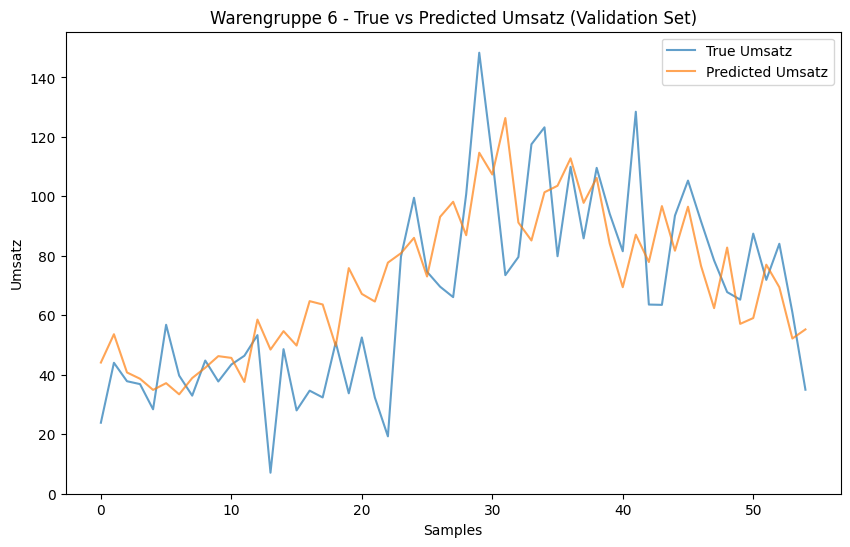


 Combined (weighted) metrics 
Weighted R² (train): 0.668
Weighted R² (val):   0.523
Weighted MAPE (val): 17.22%


,warengruppe,n_val,r2_train,r2_val,mse_train,mae_train,mape_train,mse_val,mae_val,mape_val
0,1,357,0.624006,0.531980,593.303207,18.223457,16.604103,839.877324,21.713486,18.486363
1,2,357,0.891693,0.895817,2165.690597,31.122087,7.635367,1674.423644,31.038527,8.862099
2,3,357,0.875738,0.870818,708.032253,18.641296,12.661549,741.599401,20.475844,14.246523
3,4,357,0.602685,0.084989,550.106819,16.541651,19.471947,640.332069,19.294801,24.477343
4,5,357,0.364258,0.234618,6563.057354,36.175662,12.309632,5940.852060,42.913943,16.027883
5,6,55,0.532979,0.517782,482.748082,16.548890,29.101930,470.019019,16.871505,43.050091



Saved: submission_neural_net.csv


,id,umsatz_Prediction
0,1808011,144.974915
355,1808012,619.960205
710,1808013,322.546844
1065,1808014,73.319252
1419,1808015,275.536469


In [41]:
product_groups = sorted(train_fe["warengruppe"].dropna().unique())

pred_list = []
models_by_wg = {}
results = []

for wg in product_groups:
    print("\n==============================")
    print(f" Warengruppe {wg}")
    print("==============================")

    train_wg = train_fe[train_fe["warengruppe"] == wg].copy()
    val_wg   = val_fe[val_fe["warengruppe"] == wg].copy()
    test_wg  = test_fe[test_fe["warengruppe"] == wg].copy()

    # Drop rows without target in train/val
    train_wg = train_wg.dropna(subset=[target_col])
    val_wg   = val_wg.dropna(subset=[target_col])

    # Drop rows with missing FEATURES in train/val only
    #train_wg = train_wg.dropna(subset=feature_cols)
    #val_wg   = val_wg.dropna(subset=feature_cols)

    # DO NOT drop test rows
    print(f"Rows: train={len(train_wg)}, val={len(val_wg)}, test={len(test_wg)}")

    if len(train_wg) < 50 or len(val_wg) < 20:
        print("⚠️ Too few rows for stable NN training → skipping this WG.")
        continue

    if len(test_wg) == 0:
        print("⚠️ No test rows for this WG → skipping prediction.")
        continue

    # ✅ Build X/y AFTER filtering
    X_train = train_wg[feature_cols].to_numpy()
    y_train = train_wg[target_col].to_numpy()

    X_val   = val_wg[feature_cols].to_numpy()
    y_val   = val_wg[target_col].to_numpy()

    X_test  = test_wg[feature_cols].to_numpy()

    # ✅ Impute
    imputer = SimpleImputer(strategy="mean")
    X_train = imputer.fit_transform(X_train)
    X_val   = imputer.transform(X_val)
    X_test  = imputer.transform(X_test)

    # ✅ Scale
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_val   = scaler.transform(X_val)
    X_test  = scaler.transform(X_test)

    # Train
    model = build_model(input_dim=X_train.shape[1])
    es = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)

    model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=200,
        batch_size=32,
        callbacks=[es],
        verbose=0
    )

    # Evaluate
    y_train_pred = model.predict(X_train, verbose=0).ravel()
    y_val_pred   = model.predict(X_val, verbose=0).ravel()

    r2_train = r2_score(y_train, y_train_pred)
    r2_val   = r2_score(y_val, y_val_pred)

    mse_train = mean_squared_error(y_train, y_train_pred)
    mae_train = mean_absolute_error(y_train, y_train_pred)
    mape_train = mape(y_train, y_train_pred)

    mse_val = mean_squared_error(y_val, y_val_pred)
    mae_val = mean_absolute_error(y_val, y_val_pred)
    mape_val = mape(y_val, y_val_pred)

    print(
        f"NN R² (train): {r2_train:.3f} | MSE: {mse_train:.2f} | MAE: {mae_train:.2f} | MAPE: {mape_train:.2f}%"
    )
    print(
        f"NN R² (val):   {r2_val:.3f} | MSE: {mse_val:.2f} | MAE: {mae_val:.2f} | MAPE: {mape_val:.2f}%"
    )

    #visualize
    import matplotlib.pyplot as plt
    plt.figure(figsize=(10, 6))
    plt.plot(y_val, label="True Umsatz", alpha=0.7)
    plt.plot(y_val_pred, label="Predicted Umsatz", alpha=0.7)
    plt.title(f"Warengruppe {wg} - True vs Predicted Umsatz (Validation Set)")
    plt.xlabel("Samples")
    plt.ylabel("Umsatz")
    plt.legend()
    plt.show()

    results.append({
        "warengruppe": wg,
        "n_val": len(val_wg),
        "r2_train": r2_train,
        "r2_val": r2_val,
        "mse_train": mse_train,
        "mae_train": mae_train,
        "mape_train": mape_train,
        "mse_val": mse_val,
        "mae_val": mae_val,
        "mape_val": mape_val
    })

    # Predict test
    y_test_pred = model.predict(X_test, verbose=0).ravel()

    pred_list.append(pd.DataFrame({
        "id": test_wg["id"].values,
        "umsatz_Prediction": y_test_pred
    }))

    models_by_wg[wg] = (model, scaler, imputer)

# ==============================
# Combined (weighted) evaluation
# ==============================
results_df = pd.DataFrame(results).sort_values("warengruppe")

weighted_r2_train = (results_df["r2_train"] * results_df["n_val"]).sum() / results_df["n_val"].sum()
weighted_r2_val   = (results_df["r2_val"]   * results_df["n_val"]).sum() / results_df["n_val"].sum()

weighted_mape_val = (results_df["mape_val"] * results_df["n_val"]).sum() / results_df["n_val"].sum()

print("\n==============================")
print(" Combined (weighted) metrics ")
print("==============================")
print(f"Weighted R² (train): {weighted_r2_train:.3f}")
print(f"Weighted R² (val):   {weighted_r2_val:.3f}")
print(f"Weighted MAPE (val): {weighted_mape_val:.2f}%")

display(results_df)  # optional (notebook only)

# Submission
if len(pred_list) == 0:
    raise ValueError("No predictions generated. Check test split and IDs.")

submission = pd.concat(pred_list, ignore_index=True)
submission = submission.dropna(subset=["id"]).copy()
submission["id"] = submission["id"].astype(int)
submission = submission.sort_values("id")
submission.to_csv("submission_neural_net.csv", index=False)

print("\nSaved: submission_neural_net.csv")
submission.head()